### Using depth1 and depth5 with other variables into multi-channel tensor as input and using depth9 as target.

Device: cuda


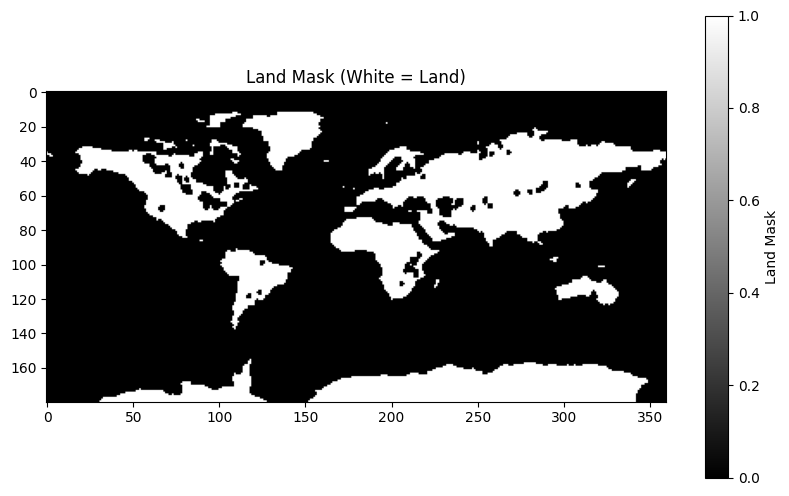

Land mask shape: (180, 360)
Epoch 1/20, Loss: 86.3695
Epoch 2/20, Loss: 58.1221
Epoch 3/20, Loss: 43.6708
Epoch 4/20, Loss: 37.4106
Epoch 5/20, Loss: 31.4103
Epoch 6/20, Loss: 28.0365
Epoch 7/20, Loss: 25.5586
Epoch 8/20, Loss: 24.0268
Epoch 9/20, Loss: 22.3264
Epoch 10/20, Loss: 19.1445
Epoch 11/20, Loss: 18.6347
Epoch 12/20, Loss: 18.0499
Epoch 13/20, Loss: 17.1658
Epoch 14/20, Loss: 16.2681
Epoch 15/20, Loss: 15.5197
Epoch 16/20, Loss: 14.9040
Epoch 17/20, Loss: 15.0097
Epoch 18/20, Loss: 13.6117
Epoch 19/20, Loss: 14.4068
Epoch 20/20, Loss: 13.0889
Average Spearman correlation over ocean: 0.9147


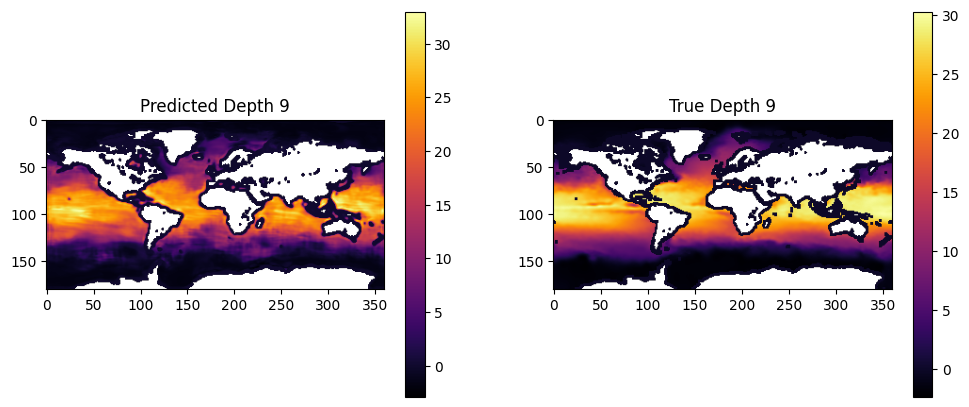

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize
from scipy.stats import spearmanr

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ Modified Data Preprocessing ============
sequence_len = 3

class MultiDepthOceanDataset(Dataset):
    def __init__(self, file_paths, land_mask, sequence_length=sequence_len):
        """
        file_paths: dictionary with keys:
            'SSH', 'SST', 'uSSW', 'vSSW': standard surface variables
            'depth1', 'depth5': inputs depths
            'depth9': target depth
        land_mask: a binary mask where True indicates land.
        """
        self.sequence_length = sequence_length
        self.land_mask = land_mask
        self.features, self.targets = self.load_data(file_paths)

    def load_data(self, file_paths):
        def read_var(path, var):
            # Read variable from netCDF and fill missing values
            data = netCDF4.Dataset(path)[var][:].filled(np.nan)
            return data

        # Standard surface variables
        SSH = read_var(file_paths['SSH'], 'SSH')
        SST = read_var(file_paths['SST'], 'SST')
        uSSW = read_var(file_paths['uSSW'], 'uSSW')
        vSSW = read_var(file_paths['vSSW'], 'vSSW')
        
        # Depth layers for input
        depth1 = read_var(file_paths['depth1'], 'ST')  # e.g., shallow measurement at 1m
        depth5 = read_var(file_paths['depth5'], 'ST')  # measurement at 5m

        # Depth layer for target
        depth9 = read_var(file_paths['depth9'], 'ST')  # deeper measurement at 9m

        # Resize each variable to a common spatial resolution, e.g. (T, 180, 360)
        SSH = resize(SSH, (SSH.shape[0], 180, 360), preserve_range=True)
        SST = resize(SST, (SST.shape[0], 180, 360), preserve_range=True)
        uSSW = resize(uSSW, (uSSW.shape[0], 180, 360), preserve_range=True)
        vSSW = resize(vSSW, (vSSW.shape[0], 180, 360), preserve_range=True)
        depth1 = resize(depth1, (depth1.shape[0], 180, 360), preserve_range=True)
        depth5 = resize(depth5, (depth5.shape[0], 180, 360), preserve_range=True)
        depth9 = resize(depth9, (depth9.shape[0], 180, 360), preserve_range=True)

        # Stack the input channels. Here we stack: [SSH, SST, uSSW, vSSW, depth1, depth5]
        X = np.stack([SSH, SST, uSSW, vSSW, depth1, depth5], axis=1)
        y = depth9  # target is the depth9 measurement

        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

        # Normalize the features; you might opt for separate scalers per channel.
        scaler = StandardScaler()
        T, C, H, W = X.shape
        X = X.reshape(T, -1)
        X = scaler.fit_transform(X).reshape(T, C, H, W)

        # Create sequences over time
        inputs, targets = [], []
        for i in range(self.sequence_length, T):
            inputs.append(X[i - self.sequence_length:i])
            targets.append(y[i])
            
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# ============ Spatial Attention Module ============
class SpatialAttention(nn.Module):
    def __init__(self, in_channels, activation='sigmoid'):
        """
        Spatial attention with a 1x1 convolution. 
        Activation can be 'sigmoid', 'softmax', or 'relu'. Here we use sigmoid.
        """
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.activation = activation

    def forward(self, x):
        attn_scores = self.conv(x)
        if self.activation == 'sigmoid':
            attn = torch.sigmoid(attn_scores)
        elif self.activation == 'softmax':
            # Flatten spatial dims, apply softmax then reshape
            B, C, H, W = attn_scores.shape
            attn = attn_scores.view(B, -1)
            attn = torch.softmax(attn, dim=1)
            attn = attn.view(B, C, H, W)
        elif self.activation == 'relu':
            attn = torch.relu(attn_scores)
        else:
            raise ValueError("Unsupported activation: choose 'sigmoid', 'softmax', or 'relu'")
        return x * attn
    
    
# ============ Model: Adjust Input Dimension ============
# Modify your ConvLSTM to accept 6 input channels rather than 4
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, dropout_prob=0.1):
        super(ConvLSTMCell, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout2d(dropout_prob)
        self.hidden_dim = hidden_dim

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_output, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = self.elu(cc_g)
        c = f * c_prev + i * g
        h = o * self.elu(c)
        h = self.dropout(h)
        return h, c

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, dropout_prob=0.1, attn_activation='sigmoid'):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cells = nn.ModuleList([
            ConvLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, kernel_size, dropout_prob=dropout_prob)
            for i in range(num_layers)
        ])
        # (Optional) You may add a spatial attention module on the final hidden state.
        self.attn = SpatialAttention(hidden_dim, activation=attn_activation)
        self.conv_out = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, x):
        B, T, C, H, W = x.size()
        h = [torch.zeros(B, self.hidden_dim, H, W, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_dim, H, W, device=x.device) for _ in range(self.num_layers)]
        for t in range(T):
            inp = x[:, t]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(inp, h[i], c[i])
                inp = h[i]
        h_attn = self.attn(h[-1])
        return self.conv_out(h_attn)

# ============ Training and Testing Loops ============
def train_model(model, train_loader, test_loader, land_mask, epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='none')
    model.to(device)
    land_mask_tensor = torch.tensor(land_mask, dtype=torch.bool).unsqueeze(0).unsqueeze(0).to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            B = outputs.size(0)
            land_mask_expanded = land_mask_tensor.expand(B, -1, -1, -1)
            ocean_mask = ~land_mask_expanded
            loss_map = criterion(outputs[ocean_mask], targets[ocean_mask])
            loss = loss_map.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

def test_model(model, test_loader, land_mask):
    model.eval()
    pred_list = []
    true_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)
            pred_list.append(preds.cpu().numpy())
            true_list.append(targets.cpu().numpy())
    pred_array = np.concatenate(pred_list, axis=0)
    true_array = np.concatenate(true_list, axis=0)
    land_mask_bool = land_mask.astype(bool)
    spearman_scores = []
    for i in range(pred_array.shape[0]):
        pred = pred_array[i, 0]
        true = true_array[i, 0]
        ocean_mask = ~land_mask_bool
        valid_preds = pred[ocean_mask]
        valid_true = true[ocean_mask]
        score, _ = spearmanr(valid_preds, valid_true)
        spearman_scores.append(score)
    print(f"Average Spearman correlation over ocean: {np.nanmean(spearman_scores):.4f}")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.flipud(np.ma.masked_where(land_mask_bool, pred_array[0, 0])), cmap='inferno')
    plt.title("Predicted Depth 9")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(np.flipud(np.ma.masked_where(land_mask_bool, true_array[0, 0])), cmap='inferno')
    plt.title("True Depth 9")
    plt.colorbar()
    plt.show()

# ============ Create binary land mask ============
def create_land_mask_2(st_file_path='project_SST_1992-2021.nc', shape=(180, 360)):
    ds = netCDF4.Dataset(st_file_path)
    st_data_full = ds.variables['SST'][:]  
    st_data_full = np.ma.filled(st_data_full, fill_value=0)
    resized_frames = [resize(frame, shape, preserve_range=True) for frame in st_data_full]
    st_resized_full = np.stack(resized_frames)
    st_mean = np.mean(st_resized_full, axis=0)
    land_mask = st_mean < 1e-3
    return land_mask

# ============ Setup ============
land_mask = create_land_mask_2()
plt.figure(figsize=(10, 6))
plt.imshow(np.flipud(land_mask), cmap='gray')
plt.title("Land Mask (White = Land)")
plt.colorbar(label='Land Mask')
plt.show()
print("Land mask shape:", land_mask.shape)

# Define file paths for all variables
file_paths = {
    'SSH': 'project_SSH_1992-2021.nc',
    'SST': 'project_SST_1992-2021.nc',
    'uSSW': 'project_uSSW_1992-2021.nc',
    'vSSW': 'project_vSSW_1992-2021.nc',
    'depth1': 'project_ST_1992-2021_dep-1.nc',  # shallow input depth
    'depth5': 'project_ST_1992-2021_dep-5.nc',  # intermediate input depth
    'depth9': 'project_ST_1992-2021_dep-9.nc'   # deep target depth
}

batch_size = 4

full_dataset = MultiDepthOceanDataset(file_paths, land_mask, sequence_length=sequence_len)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Note: Adjust the input_dim to 6 since we now use 6 channels:
model = ConvLSTM(input_dim=6, hidden_dim=32, kernel_size=7, num_layers=2, dropout_prob=0.1, attn_activation='sigmoid')

# ============ Run Training and Testing ============
train_model(model, train_loader, test_loader, land_mask, epochs=20)
test_model(model, test_loader, land_mask)


### Using depth1 and depth5 with other variables into multi-channel tensor as input and using depth9 and depth13 as target.

Device: cuda


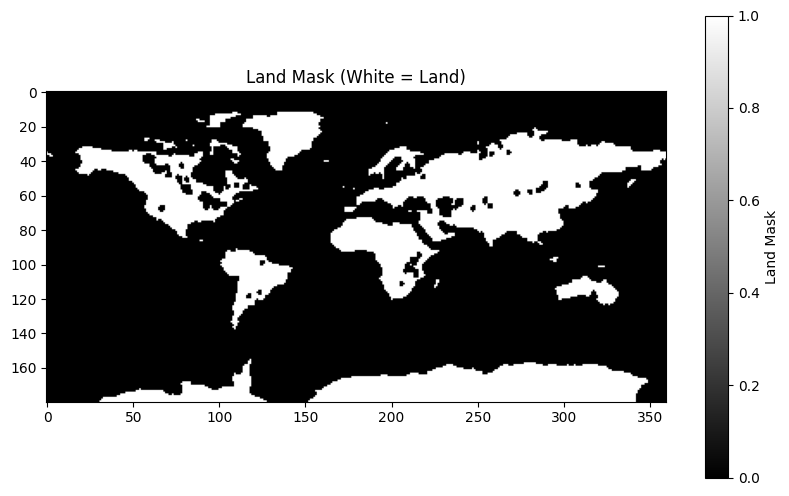

Land mask shape: (180, 360)
Epoch 1/20, Loss: 85.0764
Epoch 2/20, Loss: 54.0292
Epoch 3/20, Loss: 42.4690
Epoch 4/20, Loss: 35.9363
Epoch 5/20, Loss: 29.8931
Epoch 6/20, Loss: 26.9285
Epoch 7/20, Loss: 24.6098
Epoch 8/20, Loss: 22.3514
Epoch 9/20, Loss: 21.1504
Epoch 10/20, Loss: 19.7204
Epoch 11/20, Loss: 18.9522
Epoch 12/20, Loss: 17.8623
Epoch 13/20, Loss: 16.5619
Epoch 14/20, Loss: 16.4554
Epoch 15/20, Loss: 15.5924
Epoch 16/20, Loss: 14.8087
Epoch 17/20, Loss: 14.6893
Epoch 18/20, Loss: 14.3286
Epoch 19/20, Loss: 13.7754
Epoch 20/20, Loss: 12.8116
Average Spearman correlation over ocean: 0.9162


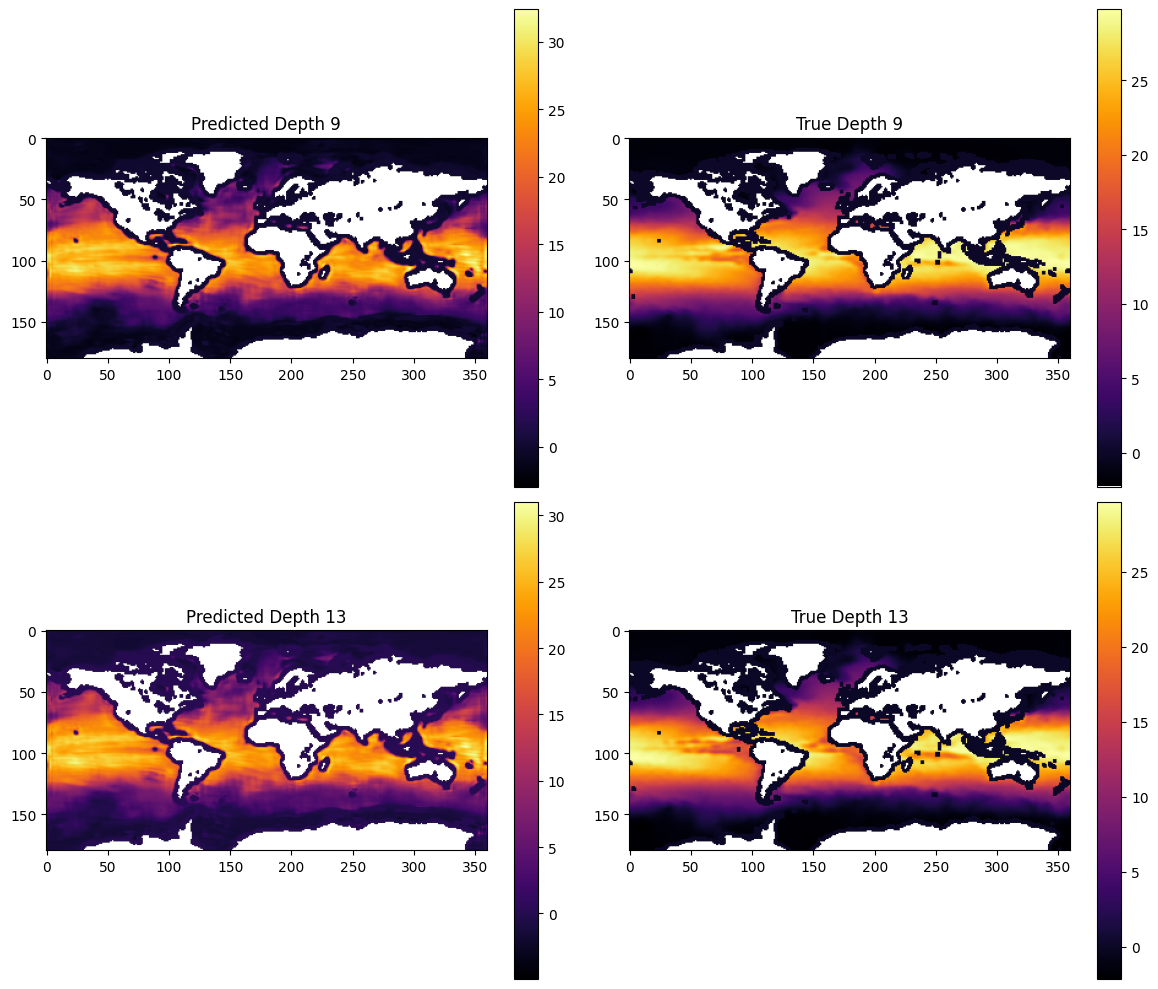

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from skimage.transform import resize

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ Multi-Target Data Preprocessing ============
sequence_len = 3

class MultiDepthOceanDataset(Dataset):
    def __init__(self, file_paths, land_mask, sequence_length=sequence_len):
        """
        file_paths: dictionary with keys for variables:
            'SSH', 'SST', 'uSSW', 'vSSW': standard surface variables
            'depth1', 'depth5': shallow/intermediate inputs
            'depth9', 'depth13': targets (depths to predict)
        land_mask: binary mask (True for land).
        """
        self.sequence_length = sequence_length
        self.land_mask = land_mask
        self.features, self.targets = self.load_data(file_paths)

    def load_data(self, file_paths):
        def read_var(path, var):
            # Read the variable and fill missing values
            data = netCDF4.Dataset(path)[var][:].filled(np.nan)
            return data

        # Standard surface variables
        SSH   = read_var(file_paths['SSH'], 'SSH')
        SST   = read_var(file_paths['SST'], 'SST')
        uSSW  = read_var(file_paths['uSSW'], 'uSSW')
        vSSW  = read_var(file_paths['vSSW'], 'vSSW')
        
        # Shallow/intermediate depths used as inputs
        depth1 = read_var(file_paths['depth1'], 'ST')  # e.g. depth 1
        depth5 = read_var(file_paths['depth5'], 'ST')  # e.g. depth 5
        
        # Targets: the deeper measurements to predict
        depth9  = read_var(file_paths['depth9'], 'ST')   # e.g. depth 9
        depth13 = read_var(file_paths['depth13'], 'ST')   # e.g. depth 13

        # Resize all variables to a common spatial resolution, e.g. (T, 180, 360)
        SSH    = resize(SSH,   (SSH.shape[0], 180, 360), preserve_range=True)
        SST    = resize(SST,   (SST.shape[0], 180, 360), preserve_range=True)
        uSSW   = resize(uSSW,  (uSSW.shape[0], 180, 360), preserve_range=True)
        vSSW   = resize(vSSW,  (vSSW.shape[0], 180, 360), preserve_range=True)
        depth1 = resize(depth1,(depth1.shape[0], 180, 360), preserve_range=True)
        depth5 = resize(depth5,(depth5.shape[0], 180, 360), preserve_range=True)
        depth9 = resize(depth9,(depth9.shape[0], 180, 360), preserve_range=True)
        depth13 = resize(depth13,(depth13.shape[0], 180, 360), preserve_range=True)

        # Stack input channels: [SSH, SST, uSSW, vSSW, depth1, depth5]
        X = np.stack([SSH, SST, uSSW, vSSW, depth1, depth5], axis=1)
        # Stack targets along a new channel: [depth9, depth13]
        y = np.stack([depth9, depth13], axis=1)

        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

        # Normalize features (using a single scaler here for simplicity)
        scaler = StandardScaler()
        T, C, H, W = X.shape
        X = X.reshape(T, -1)
        X = scaler.fit_transform(X).reshape(T, C, H, W)

        # Create sequences from the time series
        inputs, targets = [], []
        for i in range(self.sequence_length, T):
            inputs.append(X[i - self.sequence_length:i])
            targets.append(y[i])  # target shape: (2, H, W)
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# ============ Model: ConvLSTM with Multi-Target Output ============
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, dropout_prob=0.1):
        super(ConvLSTMCell, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout2d(dropout_prob)
        self.hidden_dim = hidden_dim

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_output, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = self.elu(cc_g)
        c = f * c_prev + i * g
        h = o * self.elu(c)
        h = self.dropout(h)
        return h, c

class SpatialAttention(nn.Module):
    def __init__(self, in_channels, activation='sigmoid'):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.activation = activation

    def forward(self, x):
        attn_scores = self.conv(x)
        if self.activation == 'sigmoid':
            attn = torch.sigmoid(attn_scores)
        elif self.activation == 'softmax':
            B, C, H, W = attn_scores.shape
            attn = attn_scores.view(B, -1)
            attn = torch.softmax(attn, dim=1)
            attn = attn.view(B, C, H, W)
        elif self.activation == 'relu':
            attn = torch.relu(attn_scores)
        else:
            raise ValueError("Unsupported activation.")
        return x * attn

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, dropout_prob=0.1, attn_activation='sigmoid', num_targets=2):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cells = nn.ModuleList([
            ConvLSTMCell(input_dim if i==0 else hidden_dim, hidden_dim, kernel_size, dropout_prob=dropout_prob)
            for i in range(num_layers)
        ])
        self.attn = SpatialAttention(hidden_dim, activation=attn_activation)
        # Output layer now maps to num_targets channels (2 in this case)
        self.conv_out = nn.Conv2d(hidden_dim, num_targets, kernel_size=1)

    def forward(self, x):
        # x has shape: (B, T, C, H, W)
        B, T, C, H, W = x.size()
        h = [torch.zeros(B, self.hidden_dim, H, W, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_dim, H, W, device=x.device) for _ in range(self.num_layers)]
        for t in range(T):
            inp = x[:, t]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(inp, h[i], c[i])
                inp = h[i]
        h_attn = self.attn(h[-1])
        return self.conv_out(h_attn)

# ============ Training and Testing Loops ============
def train_model(model, train_loader, test_loader, land_mask, epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='none')
    model.to(device)
    # Prepare land mask tensor with shape (1, 1, H, W)
    land_mask_tensor = torch.tensor(land_mask, dtype=torch.bool).unsqueeze(0).unsqueeze(0).to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # targets shape: (B, 2, H, W)
            outputs = model(inputs)  # outputs shape: (B, 2, H, W)
            B = outputs.size(0)
            # Expand the mask to have same channel dimensions as outputs
            land_mask_expanded = land_mask_tensor.expand(B, outputs.size(1), -1, -1)
            ocean_mask = ~land_mask_expanded
            loss_map = criterion(outputs[ocean_mask], targets[ocean_mask])
            loss = loss_map.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

def test_model(model, test_loader, land_mask):
    model.eval()
    pred_list = []
    true_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)
            pred_list.append(preds.cpu().numpy())
            true_list.append(targets.cpu().numpy())
    pred_array = np.concatenate(pred_list, axis=0)  # shape: (N, 2, H, W)
    true_array = np.concatenate(true_list, axis=0)
    land_mask_bool = land_mask.astype(bool)
    spearman_scores = []
    # Compute Spearman correlation for each sample and for each target channel
    for i in range(pred_array.shape[0]):
        channel_scores = []
        for ch in range(pred_array.shape[1]):
            pred = pred_array[i, ch]
            true = true_array[i, ch]
            ocean_mask = ~land_mask_bool
            valid_preds = pred[ocean_mask]
            valid_true = true[ocean_mask]
            score, _ = spearmanr(valid_preds, valid_true)
            channel_scores.append(score)
        spearman_scores.append(np.mean(channel_scores))
    print(f"Average Spearman correlation over ocean: {np.nanmean(spearman_scores):.4f}")
    
    # Plot predictions for both targets: depth 9 and depth 13.
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    # Row 0: Depth 9
    im1 = axs[0, 0].imshow(np.flipud(np.ma.masked_where(land_mask_bool, pred_array[0, 0])), cmap='inferno')
    axs[0, 0].set_title("Predicted Depth 9")
    fig.colorbar(im1, ax=axs[0, 0])
    im2 = axs[0, 1].imshow(np.flipud(np.ma.masked_where(land_mask_bool, true_array[0, 0])), cmap='inferno')
    axs[0, 1].set_title("True Depth 9")
    fig.colorbar(im2, ax=axs[0, 1])
    # Row 1: Depth 13
    im3 = axs[1, 0].imshow(np.flipud(np.ma.masked_where(land_mask_bool, pred_array[0, 1])), cmap='inferno')
    axs[1, 0].set_title("Predicted Depth 13")
    fig.colorbar(im3, ax=axs[1, 0])
    im4 = axs[1, 1].imshow(np.flipud(np.ma.masked_where(land_mask_bool, true_array[0, 1])), cmap='inferno')
    axs[1, 1].set_title("True Depth 13")
    fig.colorbar(im4, ax=axs[1, 1])
    plt.tight_layout()
    plt.show()

# ============ Create Binary Land Mask ============
def create_land_mask_2(st_file_path='project_SST_1992-2021.nc', shape=(180, 360)):
    ds = netCDF4.Dataset(st_file_path)
    st_data_full = ds.variables['SST'][:]  
    st_data_full = np.ma.filled(st_data_full, fill_value=0)
    resized_frames = [resize(frame, shape, preserve_range=True) for frame in st_data_full]
    st_resized_full = np.stack(resized_frames)
    st_mean = np.mean(st_resized_full, axis=0)
    land_mask = st_mean < 1e-3
    return land_mask

# ============ Setup ============
land_mask = create_land_mask_2()
plt.figure(figsize=(10, 6))
plt.imshow(np.flipud(land_mask), cmap='gray')
plt.title("Land Mask (White = Land)")
plt.colorbar(label='Land Mask')
plt.show()
print("Land mask shape:", land_mask.shape)

# Define file paths
file_paths = {
    'SSH': 'project_SSH_1992-2021.nc',
    'SST': 'project_SST_1992-2021.nc',
    'uSSW': 'project_uSSW_1992-2021.nc',
    'vSSW': 'project_vSSW_1992-2021.nc',
    'depth1': 'project_ST_1992-2021_dep-1.nc',    # shallow depth
    'depth5': 'project_ST_1992-2021_dep-5.nc',      # intermediate depth
    'depth9': 'project_ST_1992-2021_dep-9.nc',      # target depth (9m)
    'depth13': 'project_ST_1992-2021_dep-13.nc'     # target depth (13m)
}

batch_size = 4
full_dataset = MultiDepthOceanDataset(file_paths, land_mask, sequence_length=sequence_len)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Adjust the model's input channels to 6 and output channels to 2 (for depths 9 and 13)
model = ConvLSTM(input_dim=6, hidden_dim=32, kernel_size=7, num_layers=2,
                 dropout_prob=0.1, attn_activation='sigmoid', num_targets=2)

# ============ Run Training and Testing ============
train_model(model, train_loader, test_loader, land_mask, epochs=20)
test_model(model, test_loader, land_mask)


Device: cuda


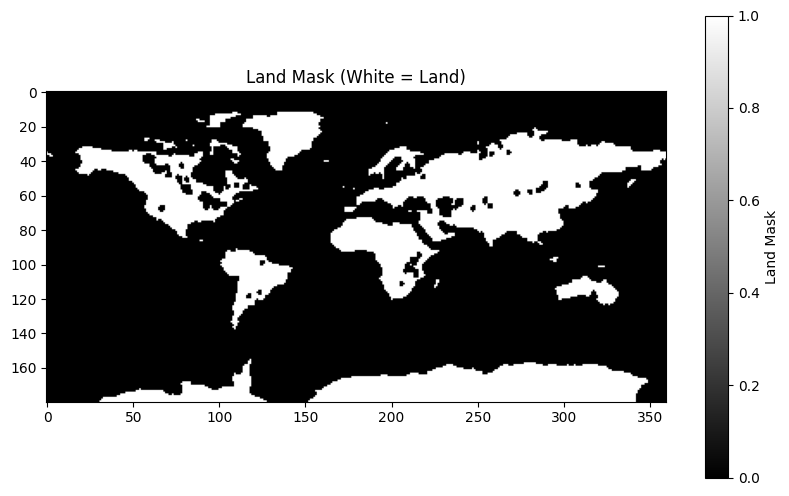

Land mask shape: (180, 360)


/tmp/ipykernel_2767020/4197882605.py:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


Epoch 1/20, Loss: 85.8692
Epoch 2/20, Loss: 56.5271
Epoch 3/20, Loss: 44.6479
Epoch 4/20, Loss: 35.6073
Epoch 5/20, Loss: 31.7380
Epoch 6/20, Loss: 29.2229
Epoch 7/20, Loss: 26.0473
Epoch 8/20, Loss: 24.0676
Epoch 9/20, Loss: 22.0727
Epoch 10/20, Loss: 21.3902
Epoch 11/20, Loss: 20.4750
Epoch 12/20, Loss: 18.8581
Epoch 13/20, Loss: 17.8063
Epoch 14/20, Loss: 17.1230
Epoch 15/20, Loss: 16.2318
Epoch 16/20, Loss: 15.3934
Epoch 17/20, Loss: 14.5813
Epoch 18/20, Loss: 14.5101
Epoch 19/20, Loss: 13.1146
Epoch 20/20, Loss: 12.9144
Average Spearman correlation over ocean: 0.9177


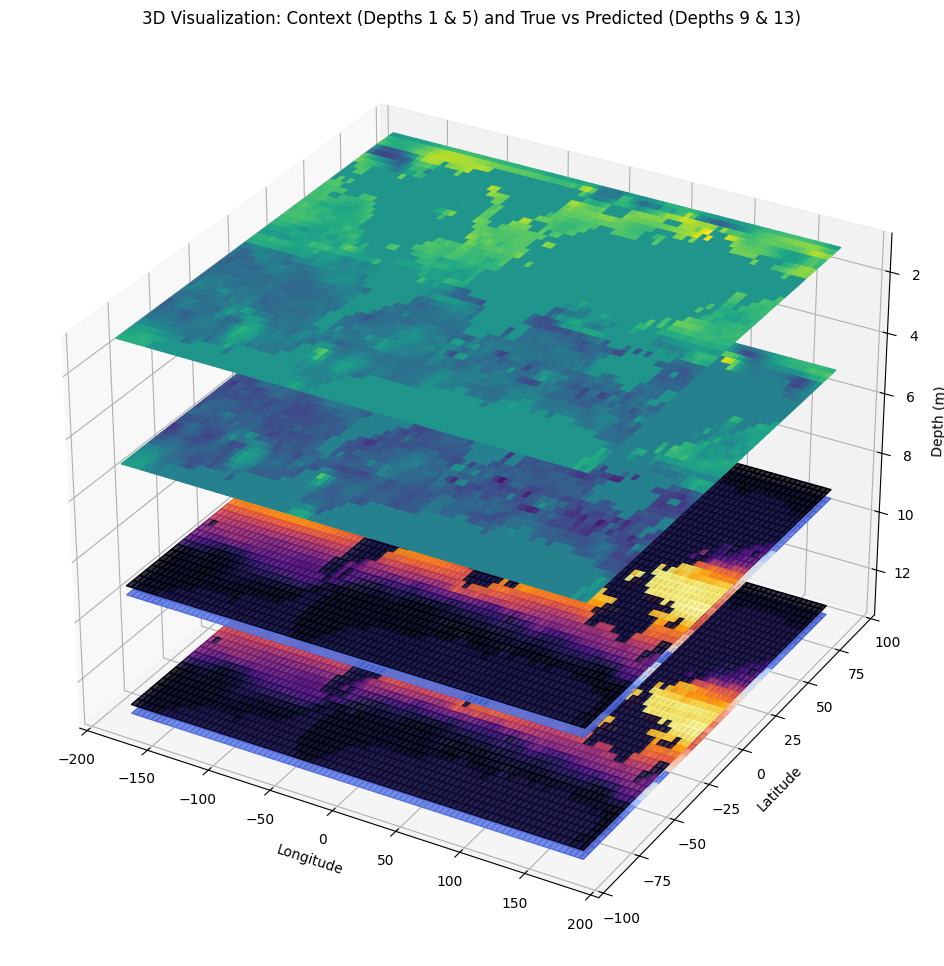

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import netCDF4
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ Multi-Target Data Preprocessing ============
sequence_len = 3

class MultiDepthOceanDataset(Dataset):
    def __init__(self, file_paths, land_mask, sequence_length=sequence_len):
        """
        file_paths: dictionary with keys for variables:
            'SSH', 'SST', 'uSSW', 'vSSW': surface variables
            'depth1', 'depth5': shallow/intermediate inputs
            'depth9', 'depth13': targets (depths to predict)
        land_mask: binary mask (True for land).
        """
        self.sequence_length = sequence_length
        self.land_mask = land_mask
        self.features, self.targets = self.load_data(file_paths)

    def load_data(self, file_paths):
        def read_var(path, var):
            data = netCDF4.Dataset(path)[var][:].filled(np.nan)
            return data

        # Standard surface variables
        SSH   = read_var(file_paths['SSH'], 'SSH')
        SST   = read_var(file_paths['SST'], 'SST')
        uSSW  = read_var(file_paths['uSSW'], 'uSSW')
        vSSW  = read_var(file_paths['vSSW'], 'vSSW')
        
        # Shallow/intermediate depths used as inputs
        depth1 = read_var(file_paths['depth1'], 'ST')
        depth5 = read_var(file_paths['depth5'], 'ST')
        
        # Targets: the deeper measurements to predict
        depth9  = read_var(file_paths['depth9'], 'ST')
        depth13 = read_var(file_paths['depth13'], 'ST')

        # Resize to a common spatial resolution (e.g., (T, 180, 360))
        SSH    = resize(SSH,   (SSH.shape[0], 180, 360), preserve_range=True)
        SST    = resize(SST,   (SST.shape[0], 180, 360), preserve_range=True)
        uSSW   = resize(uSSW,  (uSSW.shape[0], 180, 360), preserve_range=True)
        vSSW   = resize(vSSW,  (vSSW.shape[0], 180, 360), preserve_range=True)
        depth1 = resize(depth1,(depth1.shape[0], 180, 360), preserve_range=True)
        depth5 = resize(depth5,(depth5.shape[0], 180, 360), preserve_range=True)
        depth9 = resize(depth9,(depth9.shape[0], 180, 360), preserve_range=True)
        depth13 = resize(depth13,(depth13.shape[0], 180, 360), preserve_range=True)

        # Stack input channels: [SSH, SST, uSSW, vSSW, depth1, depth5]
        X = np.stack([SSH, SST, uSSW, vSSW, depth1, depth5], axis=1)
        # Stack targets: [depth9, depth13] (each target is a 2D field)
        y = np.stack([depth9, depth13], axis=1)

        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

        scaler = StandardScaler()
        T, C, H, W = X.shape
        X = X.reshape(T, -1)
        X = scaler.fit_transform(X).reshape(T, C, H, W)

        inputs, targets = [], []
        for i in range(self.sequence_length, T):
            inputs.append(X[i - self.sequence_length:i])
            targets.append(y[i])  # target shape: (2, H, W)
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# ============ Model: ConvLSTM with Multi-Target Output ============
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, dropout_prob=0.1):
        super(ConvLSTMCell, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout2d(dropout_prob)
        self.hidden_dim = hidden_dim

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_output, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = self.elu(cc_g)
        c = f * c_prev + i * g
        h = o * self.elu(c)
        h = self.dropout(h)
        return h, c

class SpatialAttention(nn.Module):
    def __init__(self, in_channels, activation='sigmoid'):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.activation = activation

    def forward(self, x):
        attn_scores = self.conv(x)
        if self.activation == 'sigmoid':
            attn = torch.sigmoid(attn_scores)
        elif self.activation == 'softmax':
            B, C, H, W = attn_scores.shape
            attn = attn_scores.view(B, -1)
            attn = torch.softmax(attn, dim=1)
            attn = attn.view(B, C, H, W)
        elif self.activation == 'relu':
            attn = torch.relu(attn_scores)
        else:
            raise ValueError("Unsupported activation.")
        return x * attn

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 dropout_prob=0.1, attn_activation='sigmoid', num_targets=2):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cells = nn.ModuleList([
            ConvLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, kernel_size, dropout_prob=dropout_prob)
            for i in range(num_layers)
        ])
        self.attn = SpatialAttention(hidden_dim, activation=attn_activation)
        self.conv_out = nn.Conv2d(hidden_dim, num_targets, kernel_size=1)

    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.size()
        h = [torch.zeros(B, self.hidden_dim, H, W, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_dim, H, W, device=x.device) for _ in range(self.num_layers)]
        for t in range(T):
            inp = x[:, t]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(inp, h[i], c[i])
                inp = h[i]
        h_attn = self.attn(h[-1])
        return self.conv_out(h_attn)

# ============ Training and Testing Loops ============
def train_model(model, train_loader, test_loader, land_mask, epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='none')
    model.to(device)
    land_mask_tensor = torch.tensor(land_mask, dtype=torch.bool).unsqueeze(0).unsqueeze(0).to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # targets: (B,2,H,W)
            outputs = model(inputs)  # outputs: (B,2,H,W)
            B = outputs.size(0)
            land_mask_expanded = land_mask_tensor.expand(B, outputs.size(1), -1, -1)
            ocean_mask = ~land_mask_expanded
            loss_map = criterion(outputs[ocean_mask], targets[ocean_mask])
            loss = loss_map.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

def test_model(model, test_loader, land_mask):
    model.eval()
    pred_list = []
    true_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)
            pred_list.append(preds.cpu().numpy())
            true_list.append(targets.cpu().numpy())
    pred_array = np.concatenate(pred_list, axis=0)  # (N,2,H,W)
    true_array = np.concatenate(true_list, axis=0)
    land_mask_bool = land_mask.astype(bool)
    
    # Calculate and print Spearman correlation (averaged over channels)
    spearman_scores = []
    for i in range(pred_array.shape[0]):
        channel_scores = []
        for ch in range(pred_array.shape[1]):
            pred = pred_array[i, ch]
            true = true_array[i, ch]
            ocean_mask = ~land_mask_bool
            valid_preds = pred[ocean_mask]
            valid_true = true[ocean_mask]
            score, _ = spearmanr(valid_preds, valid_true)
            channel_scores.append(score)
        spearman_scores.append(np.mean(channel_scores))
    print(f"Average Spearman correlation over ocean: {np.nanmean(spearman_scores):.4f}")

    # ----------------- 3D Visualization -----------------
    visualize_3d_profiles(test_loader, pred_array, true_array, land_mask, test_dataset)

def visualize_3d_profiles(test_loader, pred_array, true_array, land_mask, test_dataset):
    """
    This function creates a 3D plot that includes:
      - Observed depths 1 and 5 (from the input features) for context,
      - True and predicted values for depths 9 and 13.
    We assume that the nominal depths are: 1, 5, 9, and 13 (meters).
    """
    # For synthetic coordinates, assume the spatial resolution is the shape of the land_mask.
    H, W = land_mask.shape
    lats = np.linspace(-90, 90, H)
    lons = np.linspace(-180, 180, W)
    LONS, LATS = np.meshgrid(lons, lats)
    
    # Nominal depths
    depth_levels = {
        'd1': 1,
        'd5': 5,
        'd9': 9,
        'd13': 13
    }
    
    # Get a sample from the test dataset to retrieve the observed depths for 1 and 5
    sample_features, sample_targets = test_dataset[0]
    # sample_features shape: (T, 6, H, W); use the last time step channels 4 (depth1) and 5 (depth5)
    d1_obs = sample_features[-1, 4].cpu().numpy()
    d5_obs = sample_features[-1, 5].cpu().numpy()
    
    # For predicted and true deeper layers, get sample 0 from the prediction arrays.
    # True depth9 (channel 0) and depth13 (channel 1)
    d9_true = true_array[0, 0]
    d13_true = true_array[0, 1]
    d9_pred = pred_array[0, 0]
    d13_pred = pred_array[0, 1]
    
    # To map data values to colors, define a helper that normalizes data and returns facecolors.
    def get_facecolors(data, cmap_name='viridis'):
        norm = plt.Normalize(vmin=np.min(data), vmax=np.max(data))
        cmap = plt.get_cmap(cmap_name)
        return cmap(norm(data))
    
    # Get facecolors for each layer:
    fc_d1 = get_facecolors(d1_obs, cmap_name='viridis')
    fc_d5 = get_facecolors(d5_obs, cmap_name='viridis')
    fc_d9_true = get_facecolors(d9_true, cmap_name='inferno')
    fc_d9_pred = get_facecolors(d9_pred, cmap_name='coolwarm')
    fc_d13_true = get_facecolors(d13_true, cmap_name='inferno')
    fc_d13_pred = get_facecolors(d13_pred, cmap_name='coolwarm')
    
    # Create a 3D plot
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot observed surfaces for depths 1 and 5 (use full opacity)
    ax.plot_surface(LONS, LATS, np.full_like(LONS, depth_levels['d1']),
                    facecolors=fc_d1, rstride=4, cstride=4, shade=False)
    ax.plot_surface(LONS, LATS, np.full_like(LONS, depth_levels['d5']),
                    facecolors=fc_d5, rstride=4, cstride=4, shade=False)
    
    # For depth 9, plot the true surface at z=9 and the predicted surface slightly offset (e.g., z=9+0.3)
    ax.plot_surface(LONS, LATS, np.full_like(LONS, depth_levels['d9']),
                    facecolors=fc_d9_true, rstride=4, cstride=4, shade=False, alpha=0.8)
    ax.plot_surface(LONS, LATS, np.full_like(LONS, depth_levels['d9']+0.3),
                    facecolors=fc_d9_pred, rstride=4, cstride=4, shade=False, alpha=0.8)
    
    # For depth 13, plot the true surface at z=13 and predicted surface slightly offset (e.g., z=13+0.3)
    ax.plot_surface(LONS, LATS, np.full_like(LONS, depth_levels['d13']),
                    facecolors=fc_d13_true, rstride=4, cstride=4, shade=False, alpha=0.8)
    ax.plot_surface(LONS, LATS, np.full_like(LONS, depth_levels['d13']+0.3),
                    facecolors=fc_d13_pred, rstride=4, cstride=4, shade=False, alpha=0.8)
    
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_zlabel("Depth (m)")
    ax.set_title("3D Visualization: Context (Depths 1 & 5) and True vs Predicted (Depths 9 & 13)")
    ax.invert_zaxis()  # so that surface is at the top
    plt.show()

# ============ Create Binary Land Mask ============
def create_land_mask_2(st_file_path='project_SST_1992-2021.nc', shape=(180, 360)):
    ds = netCDF4.Dataset(st_file_path)
    st_data_full = ds.variables['SST'][:]
    st_data_full = np.ma.filled(st_data_full, fill_value=0)
    resized_frames = [resize(frame, shape, preserve_range=True) for frame in st_data_full]
    st_resized_full = np.stack(resized_frames)
    st_mean = np.mean(st_resized_full, axis=0)
    land_mask = st_mean < 1e-3
    return land_mask

# ============ Setup ============
land_mask = create_land_mask_2()
plt.figure(figsize=(10, 6))
plt.imshow(np.flipud(land_mask), cmap='gray')
plt.title("Land Mask (White = Land)")
plt.colorbar(label='Land Mask')
plt.show()
print("Land mask shape:", land_mask.shape)

# Define file paths (adjust as needed)
file_paths = {
    'SSH': 'project_SSH_1992-2021.nc',
    'SST': 'project_SST_1992-2021.nc',
    'uSSW': 'project_uSSW_1992-2021.nc',
    'vSSW': 'project_vSSW_1992-2021.nc',
    'depth1': 'project_ST_1992-2021_dep-1.nc',
    'depth5': 'project_ST_1992-2021_dep-5.nc',
    'depth9': 'project_ST_1992-2021_dep-9.nc',
    'depth13': 'project_ST_1992-2021_dep-13.nc'
}

batch_size = 4
full_dataset = MultiDepthOceanDataset(file_paths, land_mask, sequence_length=sequence_len)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model: 6 input channels, 2 output channels
model = ConvLSTM(input_dim=6, hidden_dim=32, kernel_size=7, num_layers=2,
                 dropout_prob=0.1, attn_activation='sigmoid', num_targets=2)

# ============ Run Training and Testing ============
train_model(model, train_loader, test_loader, land_mask, epochs=20)
test_model(model, test_loader, land_mask)
